In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm, metrics
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import GridSearchCV

In [2]:
ds = fetch_openml('mnist_784')
x, y = ds.data, ds.target

x_train, x_val, y_train, y_val = train_test_split(x, y, 
                                 test_size=0.2, random_state=42)
x_train = x_train[:100]
y_train = y_train[:100]

In [3]:
x_train.shape

(100, 784)

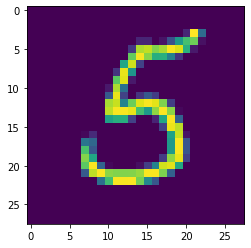

In [4]:
a = x_train[0].reshape((28, 28))
plt.imshow(a)

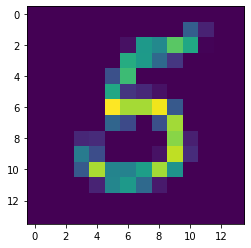

In [5]:
b = cv2.resize(a, (14, 14))
plt.imshow(b)

In [6]:
classifier = svm.SVC(C=1.0, kernel='rbf', gamma='scale')

In [7]:
def resize_images(df, old_size, new_size):
    df_copy = df
    num_samples = df_copy.shape[0]
    df_copy = df_copy.reshape((num_samples, old_size, old_size))
    downsized = np.zeros((num_samples, new_size, new_size))
    for sample in range(num_samples):
        downsized[sample] = cv2.resize(df_copy[sample], (new_size, new_size))
    downsized = downsized.reshape((num_samples, new_size**2))
    return downsized

In [8]:
resized_train = resize_images(x_train, 28, 14)
resized_test = resize_images(x_val, 28, 14)
classifier.fit(resized_train, y_train)

SVC()

In [9]:
predicted = classifier.predict(resized_test)

Classification report for classifier SVC():
              precision    recall  f1-score   support

           0       0.98      0.76      0.85      1343
           1       0.78      0.95      0.86      1600
           2       0.79      0.72      0.75      1380
           3       0.65      0.78      0.71      1433
           4       0.74      0.60      0.66      1295
           5       0.81      0.53      0.64      1273
           6       0.85      0.87      0.86      1396
           7       0.84      0.86      0.85      1503
           8       0.69      0.78      0.73      1357
           9       0.64      0.74      0.69      1420

    accuracy                           0.77     14000
   macro avg       0.78      0.76      0.76     14000
weighted avg       0.78      0.77      0.76     14000


Confusion matrix:
[[1018    1   51   61    7   37   75    7   80    6]
 [   0 1526    2   11    1    7    1    5   45    2]
 [   3   90  993   91   43    2   66   54   32    6]
 [   2   34   75 11

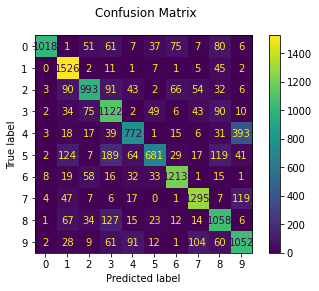

In [12]:
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(y_val, predicted)))
disp = metrics.plot_confusion_matrix(classifier, resized_test, y_val)
disp.figure_.suptitle("Confusion Matrix")
print("Confusion matrix:\n%s" % disp.confusion_matrix)

plt.show()

In [13]:
parameters = {'C': [1, 10, 50], 
#               'kernel': ('linear', 'rbf'),
#               'gamma':['scale', 'auto'],
              'shrinking':[True, False]}
#              'tol':[1e-3, 1e-2, 1e-1]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, verbose=1, cv = 2)
clf.fit(resized_test, y_val)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:  2.2min finished


GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [1, 10, 50], 'shrinking': [True, False]},
             verbose=1)

In [14]:
import pandas as pd
results = pd.DataFrame(clf.cv_results_)[['params', 'mean_test_score']]
results.head()

,params,mean_test_score
0,"{'C': 1, 'shrinking': True}",0.956786
1,"{'C': 1, 'shrinking': False}",0.956786
2,"{'C': 10, 'shrinking': True}",0.962929
3,"{'C': 10, 'shrinking': False}",0.962929
4,"{'C': 50, 'shrinking': True}",0.962714


In [15]:
results.to_csv('grid_search.csv')

In [94]:
def subsample(dataset, num_samples, num_classes):
    num_samples_per_class = int(num_samples/num_classes)
    dataset = np.array(list(map(lambda elt: (np.array(elt[0]).flatten(),elt[1]), dataset)))
    X, y = map(lambda x: np.array(list(x)),zip(*dataset))
    subsamplesX, subsamplesY = None, None

    for c in range(num_classes):
        # Get all X's where label == c
        mask = np.argwhere(y == c)
        class_X, class_Y = X[mask], y[mask]
        class_X = class_X.reshape((class_X.shape[0], X.shape[1]))
        
        # Get all X's where label == c, inds = index array
        inds = np.random.randint(0, high=class_Y.shape[0], size=num_samples_per_class)
        subsamplesX = class_X[inds] if subsamplesX is None else np.concatenate([subsamplesX, class_X[inds]])
        
        # Get all Y's where label == c
        subsamplesY = class_Y[inds] if subsamplesY is None else np.concatenate([subsamplesY, class_Y[inds]])
    
    # shuffle the arrays
    A = subsamplesX.shape[1]
    B = subsamplesX.shape[0]
    shuf_inds = np.random.shuffle(np.array(range(B)))
    return subsamplesX[shuf_inds].reshape((B,A)), subsamplesY[shuf_inds].reshape((num_samples,))

In [70]:
def subsample(X_train, y_train, num_samples, num_classes):
    num_samples_per_class = int(num_samples/num_classes)
    subsamplesX, subsamplesY = None, None
    
    for c in range(num_classes):
        # Get all X's where label == c
        mask = np.argwhere(y_train == str(c))
        
        class_X, class_Y = X_train[mask], y_train[mask]
                
        # Get all X's where label == c, inds = index array
        inds = np.random.randint(0, high=len(class_Y), size=num_samples_per_class)
        subsamplesX = class_X[inds] if subsamplesX is None else np.concatenate([subsamplesX, class_X[inds]])
        
        # Get all Y's where label == c
        subsamplesY = class_Y[inds] if subsamplesY is None else np.concatenate([subsamplesY, class_Y[inds]])
    
    # shuffle the arrays
    B = subsamplesX.shape[0]
    shuf_inds = np.random.shuffle(np.array(range(B)))
    return subsamplesX[shuf_inds], subsamplesY[shuf_inds]

In [71]:
X_train_1, y_train_1 = subsample(X_train = resized_train, y_train = y_train,
                           num_samples=500, 
                           num_classes=10)

In [83]:
print(X_train_1.shape, y_train_1.shape)

In [84]:
temp = X_train_1.reshape(500, 1, 196)

In [85]:
temp.shape

(500, 1, 196)

In [89]:
temp1 = temp.reshape(500, 196)

In [91]:
temp1.shape

(500, 196)

In [73]:
from skimage.filters import gabor_kernel, gabor
import numpy as np

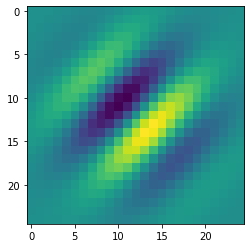

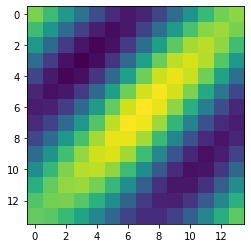

In [75]:
freq, theta, bandwidth = 0.1, np.pi/4, 1
gk = gabor_kernel(frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(gk.real)
plt.figure(2); plt.clf(); plt.imshow(gk.imag)

image = X_train_1[0][0][0].reshape((14, 14))
coeff_real, _ = gabor(image, frequency=freq, theta=theta, bandwidth=bandwidth)
plt.figure(1); plt.clf(); plt.imshow(coeff_real)

In [112]:
theta = np.arange(0, np.pi, np.pi/4)
frequency = np.arange(0.05, 0.5, 0.15)
bandwidth = np.arange(0.3, 1, 0.3)

def apply_filters(x_train, num_filters):
    num_samples = x_train.shape[0]
    sample_size  = x_train.shape[1]
    output = np.zeros((num_samples, sample_size*num_filters))
    
    curr_filter = 0
    
    for sample in range(num_samples):
        for t in theta:
            for f in frequency:
                for b in bandwidth:
                    gk = gabor_kernel(frequency=f, theta=t, bandwidth=b)
                    image = X_train_1[0][i][0].reshape((14, 14))
                    plt.imshow(image)
                    coeff_real, _ = gabor(image, frequency=f, theta=t, bandwidth=b)
                    coeff_real = coeff_real.reshape((sample_size))
                    output[sample, curr_filter*sample_size:(curr_filter+1)*sample_size] = coeff_real
                    curr_filter+= 1
    return output

ValueError: could not broadcast input array from shape (196) into shape (0)

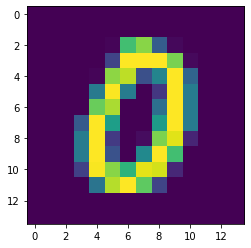

In [113]:
x_filtered = apply_filters(temp1[:2], len(theta)*len(frequency)*len(bandwidth))